In [1]:
# ============================================================
# CELL 1: SETUP & DATA COLLECTION (FIXED)
# ============================================================

!pip install yfinance --upgrade --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
import yfinance as yf

# Disable yfinance progress bars to avoid errors
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Portfolio configuration
tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'TSLA', 'JPM', 'V', 'JNJ', 'WMT', 'PG']
weights = np.array([0.1] * 10)
initial_investment = 100000

# Download data with proper syntax
print("Downloading data...")
start_date = '2019-01-01'
end_date = '2024-01-01'

# Download all tickers at once - new yfinance syntax
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, progress=False)['Close']

print(f"\n✓ Downloaded {len(data)} days of data")
print(f"  Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"  Tickers: {', '.join(tickers)}")
print(f"\nFirst few rows:")
print(data.head())


✓ Downloaded 1258 days of data
  Date range: 2019-01-02 to 2023-12-29
  Tickers: AAPL, MSFT, GOOGL, META, TSLA, JPM, V, JNJ, WMT, PG

First few rows:
Ticker           AAPL      GOOGL         JNJ        JPM        META  \
Date                                                                  
2019-01-02  37.503727  52.338547  104.942818  81.250191  134.738800   
2019-01-03  33.768074  50.889000  103.275253  80.095505  130.826126   
2019-01-04  35.209614  53.499271  105.008553  83.048256  136.993073   
2019-01-07  35.131252  53.392578  104.334953  83.105995  137.092361   
2019-01-08  35.800949  53.861542  106.758301  82.949280  141.541290   

Ticker           MSFT         PG       TSLA           V        WMT  
Date                                                                
2019-01-02  94.612602  75.915642  20.674667  126.329460  28.024441  
2019-01-03  91.131996  75.383354  20.024000  121.776955  27.880327  
2019-01-04  95.370476  76.921944  21.179333  127.023216  28.054466  
2019-0

PORTFOLIO STATISTICS

Initial Investment: $100,000
Final Value: $335,273.62
Total Return: 235.27%

Annualized Return: 26.88%
Annualized Volatility: 22.84%
Sharpe Ratio (assuming 2% risk-free): 1.09


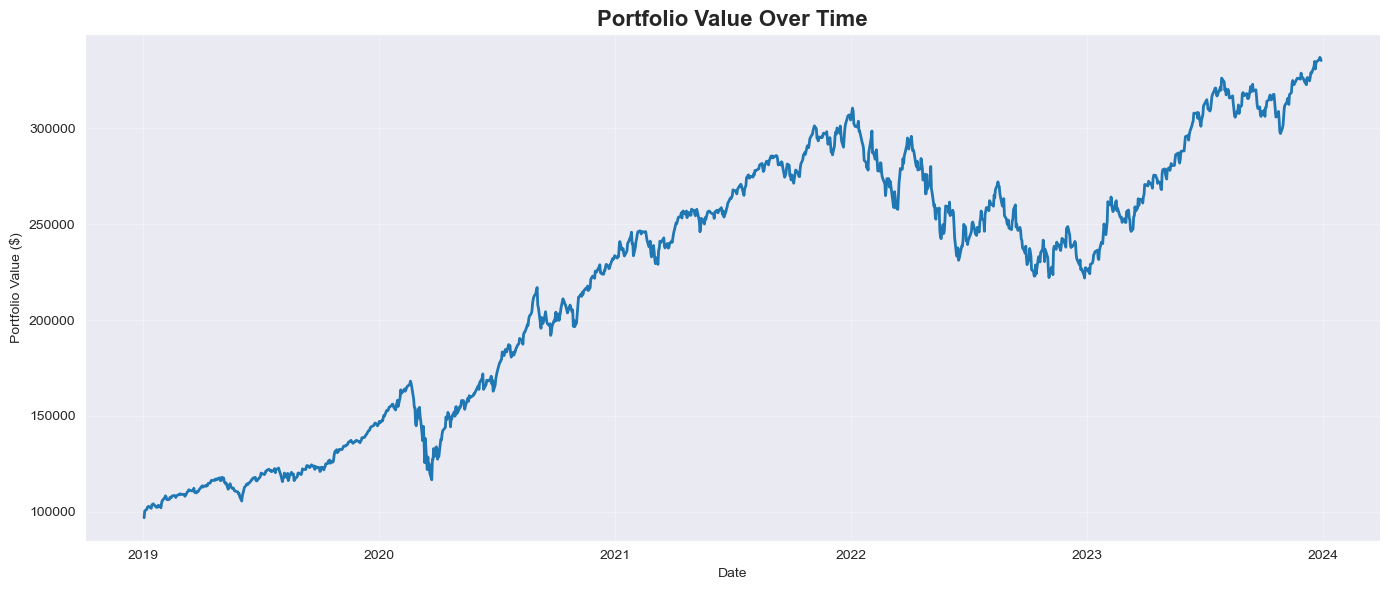


✓ Returns calculated: 1257 days


In [3]:
# ============================================================
# CELL 2: CALCULATE RETURNS & PORTFOLIO VALUE
# ============================================================

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate portfolio returns (weighted sum)
portfolio_returns = (returns * weights).sum(axis=1)

# Calculate cumulative portfolio value
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

# Basic statistics
print("="*60)
print("PORTFOLIO STATISTICS")
print("="*60)
print(f"\nInitial Investment: ${initial_investment:,.0f}")
print(f"Final Value: ${portfolio_value.iloc[-1]:,.2f}")
print(f"Total Return: {(portfolio_value.iloc[-1]/initial_investment - 1)*100:.2f}%")
print(f"\nAnnualized Return: {portfolio_returns.mean() * 252 * 100:.2f}%")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(252) * 100:.2f}%")
print(f"Sharpe Ratio (assuming 2% risk-free): {(portfolio_returns.mean() * 252 - 0.02) / (portfolio_returns.std() * np.sqrt(252)):.2f}")

# Plot portfolio value
plt.figure(figsize=(14, 6))
plt.plot(portfolio_value.index, portfolio_value.values, linewidth=2)
plt.title('Portfolio Value Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Returns calculated: {len(portfolio_returns)} days")

RISK METRICS

Maximum Drawdown: -30.59%
Sortino Ratio: 1.37
Skewness: -0.34
Kurtosis: 9.24
Best Day: 9.98%
Worst Day: -11.72%


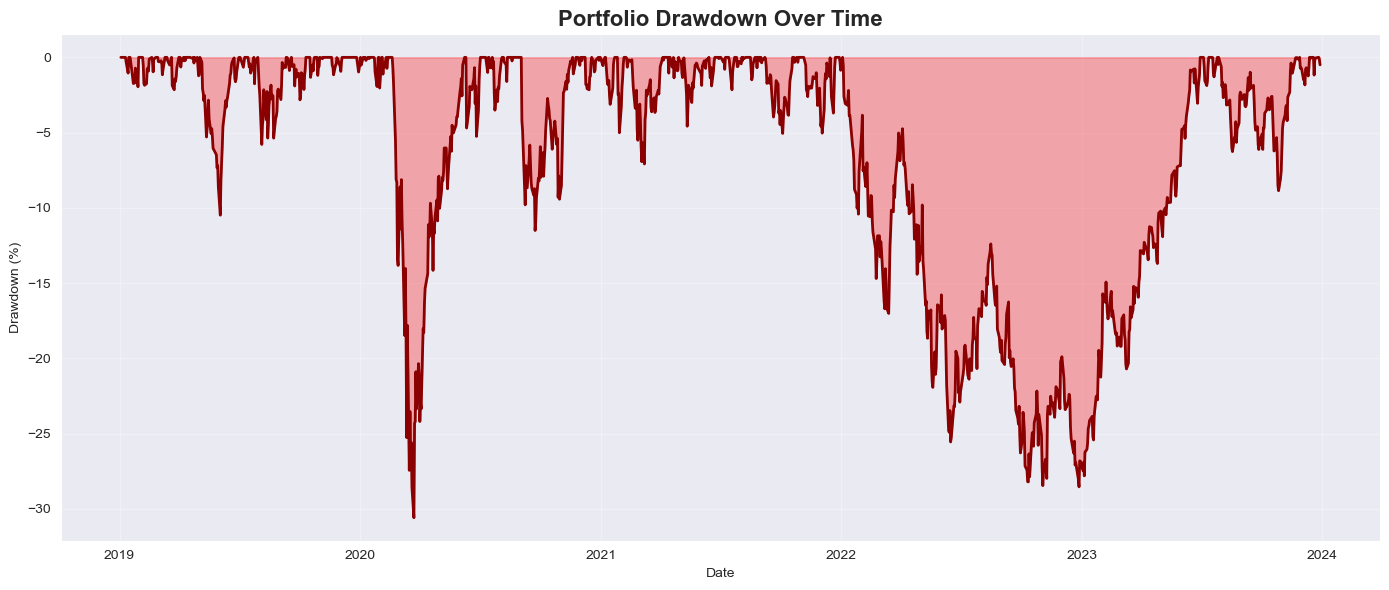


✓ Risk metrics calculated


In [5]:
# ============================================================
# CELL 3: CALCULATE RISK METRICS
# ============================================================

# Max Drawdown
def calculate_max_drawdown(returns_series):
    cum_returns = (1 + returns_series).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()
    return max_dd, drawdown

max_drawdown, drawdowns = calculate_max_drawdown(portfolio_returns)

# Sortino Ratio (only downside deviation)
downside_returns = portfolio_returns[portfolio_returns < 0]
downside_std = downside_returns.std() * np.sqrt(252)
sortino_ratio = (portfolio_returns.mean() * 252 - 0.02) / downside_std

# Print metrics
print("="*60)
print("RISK METRICS")
print("="*60)
print(f"\nMaximum Drawdown: {max_drawdown*100:.2f}%")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Skewness: {portfolio_returns.skew():.2f}")
print(f"Kurtosis: {portfolio_returns.kurtosis():.2f}")
print(f"Best Day: {portfolio_returns.max()*100:.2f}%")
print(f"Worst Day: {portfolio_returns.min()*100:.2f}%")

# Plot drawdown
plt.figure(figsize=(14, 6))
plt.fill_between(drawdowns.index, drawdowns.values*100, 0, alpha=0.3, color='red')
plt.plot(drawdowns.index, drawdowns.values*100, color='darkred', linewidth=2)
plt.title('Portfolio Drawdown Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Risk metrics calculated")

VALUE AT RISK (VaR) - 95% CONFIDENCE

Portfolio Value: $335,273.62

1. HISTORICAL VaR:
   Daily VaR: -2.07%
   Dollar VaR: $6,949.31

2. PARAMETRIC VaR (Normal Distribution):
   Daily VaR: -2.26%
   Dollar VaR: $7,577.18

3. MONTE CARLO VaR (10,000 simulations):
   Daily VaR: -2.27%
   Dollar VaR: $7,625.44

4. CONDITIONAL VaR (CVaR / Expected Shortfall):
   Daily CVaR: -3.40%
   Dollar CVaR: $11,405.43

Interpretation: We are 95% confident that daily losses
will not exceed $6,949.31 (Historical VaR)


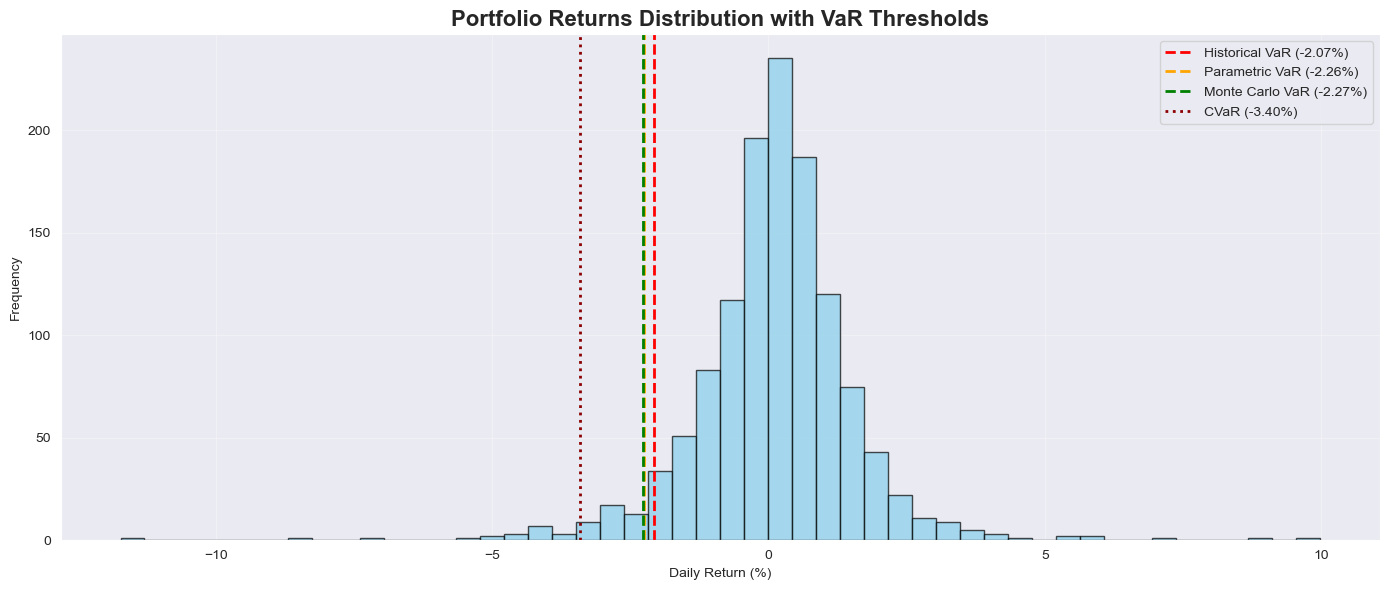


✓ VaR calculated using 3 methods


In [7]:
# ============================================================
# CELL 4: VALUE AT RISK (VaR) CALCULATION
# ============================================================

confidence_level = 0.95
portfolio_current_value = portfolio_value.iloc[-1]

# Method 1: Historical VaR
historical_var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
historical_var_dollar = portfolio_current_value * historical_var

# Method 2: Parametric VaR (assumes normal distribution)
mean_return = portfolio_returns.mean()
std_return = portfolio_returns.std()
parametric_var = mean_return - stats.norm.ppf(confidence_level) * std_return
parametric_var_dollar = portfolio_current_value * parametric_var

# Method 3: Monte Carlo VaR
np.random.seed(42)
num_simulations = 10000
simulated_returns = np.random.normal(mean_return, std_return, num_simulations)
monte_carlo_var = np.percentile(simulated_returns, (1 - confidence_level) * 100)
monte_carlo_var_dollar = portfolio_current_value * monte_carlo_var

# Conditional VaR (CVaR / Expected Shortfall) - Historical method
cvar_threshold = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
tail_losses = portfolio_returns[portfolio_returns <= cvar_threshold]
historical_cvar = tail_losses.mean()
historical_cvar_dollar = portfolio_current_value * historical_cvar

print("="*60)
print(f"VALUE AT RISK (VaR) - {confidence_level*100:.0f}% CONFIDENCE")
print("="*60)
print(f"\nPortfolio Value: ${portfolio_current_value:,.2f}")
print(f"\n1. HISTORICAL VaR:")
print(f"   Daily VaR: {historical_var*100:.2f}%")
print(f"   Dollar VaR: ${abs(historical_var_dollar):,.2f}")

print(f"\n2. PARAMETRIC VaR (Normal Distribution):")
print(f"   Daily VaR: {parametric_var*100:.2f}%")
print(f"   Dollar VaR: ${abs(parametric_var_dollar):,.2f}")

print(f"\n3. MONTE CARLO VaR ({num_simulations:,} simulations):")
print(f"   Daily VaR: {monte_carlo_var*100:.2f}%")
print(f"   Dollar VaR: ${abs(monte_carlo_var_dollar):,.2f}")

print(f"\n4. CONDITIONAL VaR (CVaR / Expected Shortfall):")
print(f"   Daily CVaR: {historical_cvar*100:.2f}%")
print(f"   Dollar CVaR: ${abs(historical_cvar_dollar):,.2f}")

print(f"\nInterpretation: We are {confidence_level*100:.0f}% confident that daily losses")
print(f"will not exceed ${abs(historical_var_dollar):,.2f} (Historical VaR)")

# Visualize VaR on distribution
plt.figure(figsize=(14, 6))
plt.hist(portfolio_returns * 100, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(historical_var * 100, color='red', linestyle='--', linewidth=2, label=f'Historical VaR ({historical_var*100:.2f}%)')
plt.axvline(parametric_var * 100, color='orange', linestyle='--', linewidth=2, label=f'Parametric VaR ({parametric_var*100:.2f}%)')
plt.axvline(monte_carlo_var * 100, color='green', linestyle='--', linewidth=2, label=f'Monte Carlo VaR ({monte_carlo_var*100:.2f}%)')
plt.axvline(historical_cvar * 100, color='darkred', linestyle=':', linewidth=2, label=f'CVaR ({historical_cvar*100:.2f}%)')
plt.title('Portfolio Returns Distribution with VaR Thresholds', fontsize=16, fontweight='bold')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ VaR calculated using 3 methods")


MONTE CARLO SIMULATION - 30 DAYS AHEAD

Simulated 1,000 scenarios
Starting value: $335,273.62

Projected values after 30 days:
  5th percentile (worst case): $304,124.80
  50th percentile (median): $345,486.83
  95th percentile (best case): $391,007.69

Probability of loss: 35.9%


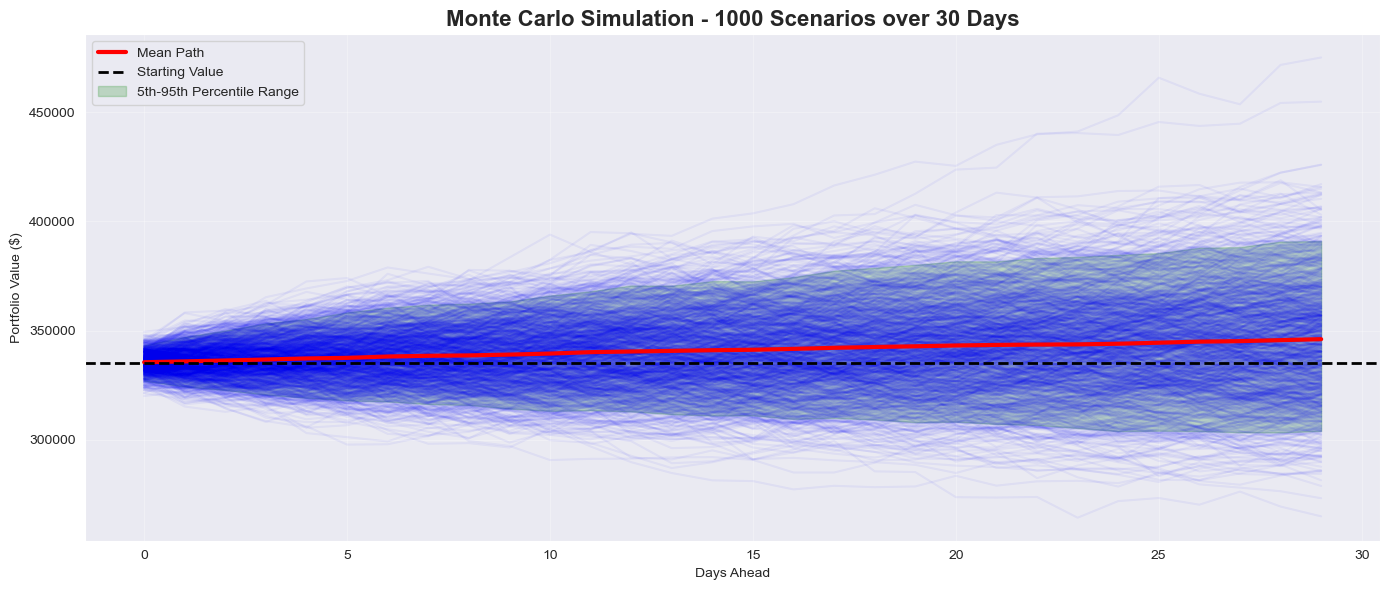


✓ Monte Carlo simulation complete


In [9]:
# ============================================================
# CELL 5: MONTE CARLO SIMULATION - STRESS TESTING
# ============================================================

# Simulate 1000 scenarios for next 30 days
num_scenarios = 1000
num_days = 30

np.random.seed(42)
simulated_paths = np.zeros((num_days, num_scenarios))

for i in range(num_scenarios):
    daily_returns = np.random.normal(mean_return, std_return, num_days)
    simulated_paths[:, i] = portfolio_current_value * (1 + daily_returns).cumprod()

# Calculate statistics
final_values = simulated_paths[-1, :]
percentile_5 = np.percentile(final_values, 5)
percentile_50 = np.percentile(final_values, 50)
percentile_95 = np.percentile(final_values, 95)

print("="*60)
print(f"MONTE CARLO SIMULATION - {num_days} DAYS AHEAD")
print("="*60)
print(f"\nSimulated {num_scenarios:,} scenarios")
print(f"Starting value: ${portfolio_current_value:,.2f}")
print(f"\nProjected values after {num_days} days:")
print(f"  5th percentile (worst case): ${percentile_5:,.2f}")
print(f"  50th percentile (median): ${percentile_50:,.2f}")
print(f"  95th percentile (best case): ${percentile_95:,.2f}")
print(f"\nProbability of loss: {(final_values < portfolio_current_value).sum() / num_scenarios * 100:.1f}%")

# Plot simulation paths
plt.figure(figsize=(14, 6))
plt.plot(simulated_paths, alpha=0.05, color='blue')
plt.plot(simulated_paths.mean(axis=1), color='red', linewidth=3, label='Mean Path')
plt.axhline(portfolio_current_value, color='black', linestyle='--', linewidth=2, label='Starting Value')
plt.fill_between(range(num_days), 
                 np.percentile(simulated_paths, 5, axis=1),
                 np.percentile(simulated_paths, 95, axis=1),
                 alpha=0.2, color='green', label='5th-95th Percentile Range')
plt.title(f'Monte Carlo Simulation - {num_scenarios} Scenarios over {num_days} Days', fontsize=16, fontweight='bold')
plt.xlabel('Days Ahead')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Monte Carlo simulation complete")

VAR BACKTESTING RESULTS

Backtest period: 1005 days
Expected violation rate: 5.0%

Historical VaR:
  Violations: 56 (5.57%)
  Status: ✓ PASS

Parametric VaR:
  Violations: 60 (5.97%)
  Status: ✓ PASS

Interpretation:
  Historical VaR model is well-calibrated!


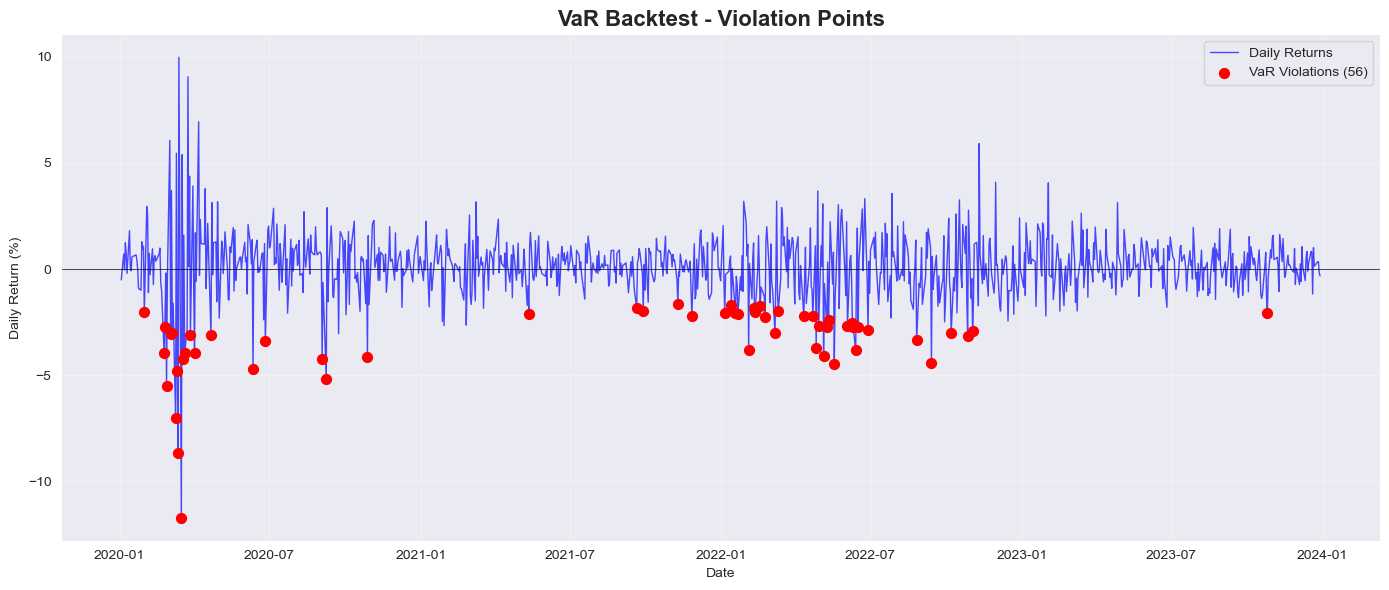


✓ Backtesting complete


In [11]:
# ============================================================
# CELL 6: VAR BACKTESTING
# ============================================================

# Backtest VaR models
# For each day, calculate 1-day VaR, then check if next day's return violates it

backtest_window = 252  # Use 1 year rolling window
backtest_start_idx = backtest_window

historical_var_violations = []
parametric_var_violations = []

historical_var_values = []
parametric_var_values = []

for i in range(backtest_start_idx, len(portfolio_returns)):
    # Get rolling window
    window = portfolio_returns.iloc[i-backtest_window:i]
    
    # Calculate VaR for this window
    hist_var = np.percentile(window, (1 - confidence_level) * 100)
    param_var = window.mean() - stats.norm.ppf(confidence_level) * window.std()
    
    historical_var_values.append(hist_var)
    parametric_var_values.append(param_var)
    
    # Check if next day violates VaR
    actual_return = portfolio_returns.iloc[i]
    
    if actual_return < hist_var:
        historical_var_violations.append(i)
    if actual_return < param_var:
        parametric_var_violations.append(i)

# Calculate violation rates
total_days = len(portfolio_returns) - backtest_start_idx
hist_violation_rate = len(historical_var_violations) / total_days
param_violation_rate = len(parametric_var_violations) / total_days
expected_violation_rate = 1 - confidence_level

print("="*60)
print("VAR BACKTESTING RESULTS")
print("="*60)
print(f"\nBacktest period: {total_days} days")
print(f"Expected violation rate: {expected_violation_rate*100:.1f}%")
print(f"\nHistorical VaR:")
print(f"  Violations: {len(historical_var_violations)} ({hist_violation_rate*100:.2f}%)")
print(f"  Status: {'✓ PASS' if abs(hist_violation_rate - expected_violation_rate) < 0.02 else '✗ FAIL'}")

print(f"\nParametric VaR:")
print(f"  Violations: {len(parametric_var_violations)} ({param_violation_rate*100:.2f}%)")
print(f"  Status: {'✓ PASS' if abs(param_violation_rate - expected_violation_rate) < 0.02 else '✗ FAIL'}")

print(f"\nInterpretation:")
if abs(hist_violation_rate - expected_violation_rate) < 0.02:
    print("  Historical VaR model is well-calibrated!")
else:
    if hist_violation_rate > expected_violation_rate:
        print("  Historical VaR model underestimates risk (too many violations)")
    else:
        print("  Historical VaR model overestimates risk (too few violations)")

# Plot violations
plt.figure(figsize=(14, 6))
backtest_returns = portfolio_returns.iloc[backtest_start_idx:]
plt.plot(backtest_returns.index, backtest_returns * 100, linewidth=1, alpha=0.7, label='Daily Returns', color='blue')

# Plot each violation
for idx in historical_var_violations:
    plt.scatter(portfolio_returns.index[idx], portfolio_returns.iloc[idx] * 100, 
               color='red', s=50, zorder=5)

# Add legend entry for violations
if len(historical_var_violations) > 0:
    plt.scatter([], [], color='red', s=50, label=f'VaR Violations ({len(historical_var_violations)})')

plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.title('VaR Backtest - Violation Points', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Backtesting complete")

CRISIS SCENARIO: COVID-19 CRASH (Feb-Mar 2020)

Period: 2020-02-19 to 2020-03-23
Duration: 24 trading days

Portfolio Performance:
  Starting value: $168,156.27
  Ending value: $116,724.85
  Total return: -30.59%
  Maximum drawdown: -30.59%
  Worst single day: -11.72%

VaR Prediction Accuracy:
  Historical VaR predicted max 1-day loss: -2.07%
  Actual worst day during crisis: -11.72%
  ⚠️  VaR was BREACHED - actual loss exceeded prediction


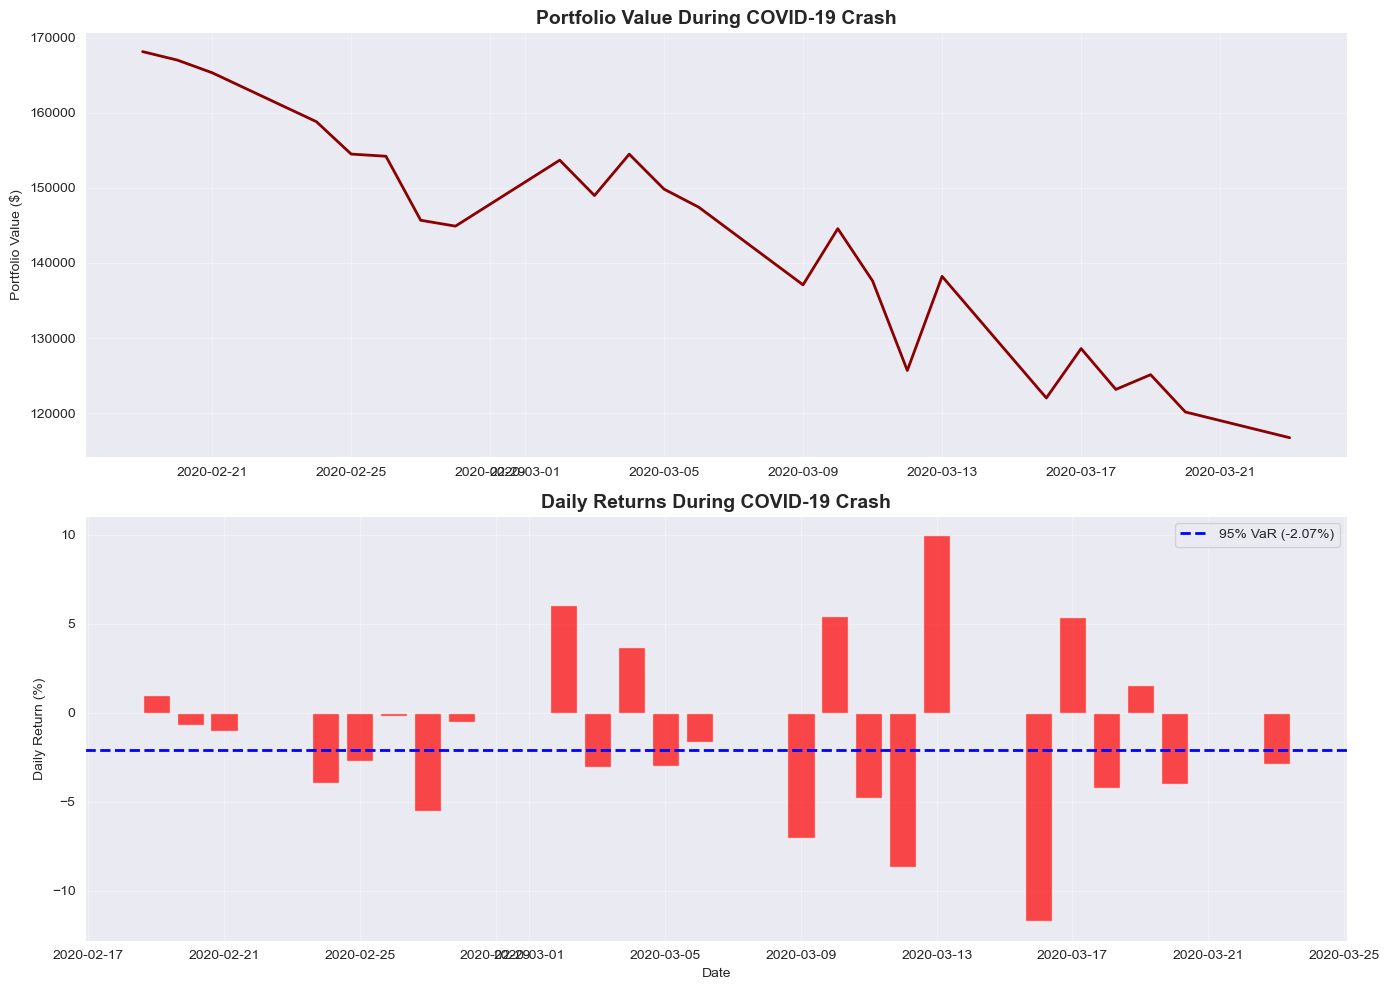


✓ Crisis analysis complete


In [13]:
# ============================================================
# CELL 7: CRISIS SCENARIO ANALYSIS - COVID-19 CRASH
# ============================================================

# Analyze March 2020 COVID crash
crisis_start = '2020-02-19'  # Market peak
crisis_end = '2020-03-23'    # Market bottom

crisis_period = portfolio_returns.loc[crisis_start:crisis_end]
crisis_portfolio_value = portfolio_value.loc[crisis_start:crisis_end]

if len(crisis_period) > 0:
    crisis_return = (crisis_portfolio_value.iloc[-1] / crisis_portfolio_value.iloc[0] - 1)
    crisis_max_dd = ((crisis_portfolio_value - crisis_portfolio_value.cummax()) / crisis_portfolio_value.cummax()).min()
    
    print("="*60)
    print("CRISIS SCENARIO: COVID-19 CRASH (Feb-Mar 2020)")
    print("="*60)
    print(f"\nPeriod: {crisis_start} to {crisis_end}")
    print(f"Duration: {len(crisis_period)} trading days")
    print(f"\nPortfolio Performance:")
    print(f"  Starting value: ${crisis_portfolio_value.iloc[0]:,.2f}")
    print(f"  Ending value: ${crisis_portfolio_value.iloc[-1]:,.2f}")
    print(f"  Total return: {crisis_return*100:.2f}%")
    print(f"  Maximum drawdown: {crisis_max_dd*100:.2f}%")
    print(f"  Worst single day: {crisis_period.min()*100:.2f}%")
    
    # Compare to VaR predictions
    print(f"\nVaR Prediction Accuracy:")
    print(f"  Historical VaR predicted max 1-day loss: {historical_var*100:.2f}%")
    print(f"  Actual worst day during crisis: {crisis_period.min()*100:.2f}%")
    if crisis_period.min() < historical_var:
        print(f"  ⚠️  VaR was BREACHED - actual loss exceeded prediction")
    else:
        print(f"  ✓ VaR held - losses within predicted range")
    
    # Plot crisis period
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Portfolio value during crisis
    ax1.plot(crisis_portfolio_value.index, crisis_portfolio_value.values, linewidth=2, color='darkred')
    ax1.set_title('Portfolio Value During COVID-19 Crash', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.grid(alpha=0.3)
    
    # Daily returns during crisis
    ax2.bar(crisis_period.index, crisis_period.values * 100, color='red', alpha=0.7)
    ax2.axhline(historical_var * 100, color='blue', linestyle='--', linewidth=2, label=f'95% VaR ({historical_var*100:.2f}%)')
    ax2.set_title('Daily Returns During COVID-19 Crash', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Daily Return (%)')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Crisis analysis complete")
else:
    print("⚠️  COVID-19 period not in dataset")

INDIVIDUAL STOCK RISK CONTRIBUTION

Portfolio Volatility: 22.84%

 Ticker  Weight  Volatility  Risk Contribution  % of Total Risk
   JNJ    10.0   64.700001           4.239812        18.562508
  TSLA    10.0   43.629978           3.152499        13.802096
  AAPL    10.0   32.234556           2.707114        11.852135
   JPM    10.0   30.490832           2.606473        11.411512
  MSFT    10.0   31.810007           2.570727        11.255014
   WMT    10.0   28.040470           2.154671         9.433458
  META    10.0   31.897717           2.044079         8.949272
     V    10.0   21.161256           1.213642         5.313500
    PG    10.0   22.071801           1.090590         4.774759
 GOOGL    10.0   19.863236           1.061122         4.645746


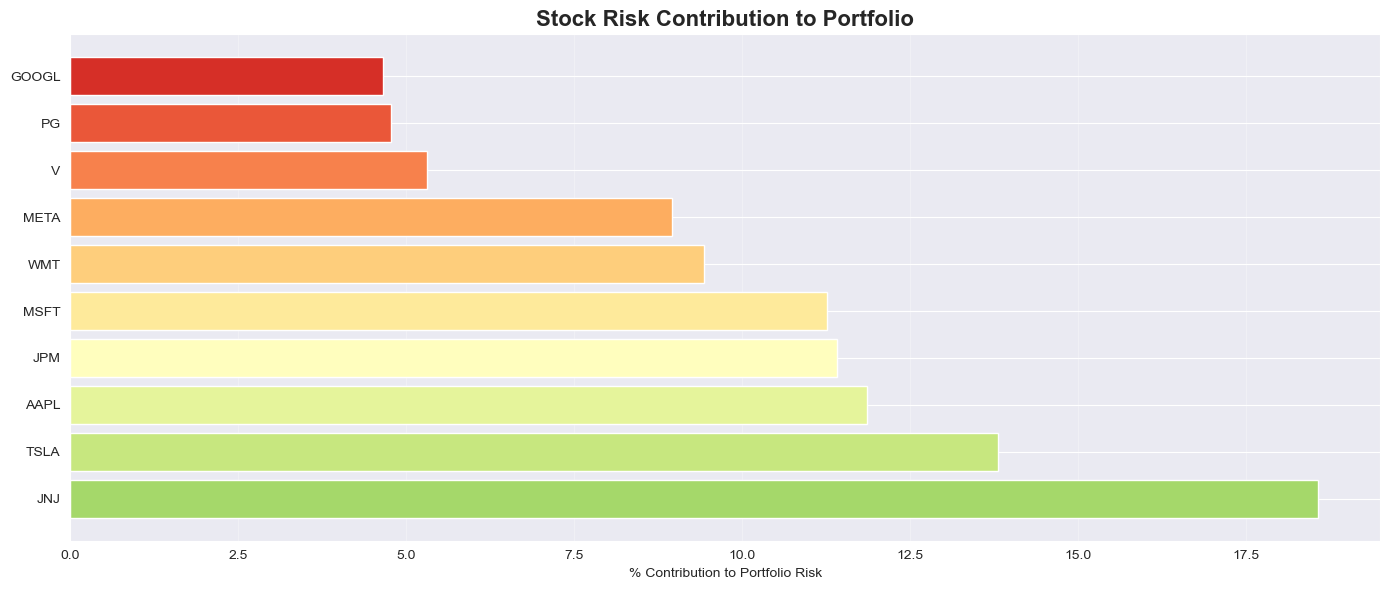


✓ Risk decomposition complete


In [15]:
# ============================================================
# CELL 8: INDIVIDUAL STOCK RISK CONTRIBUTION
# ============================================================

# Calculate each stock's contribution to portfolio risk
covariance_matrix = returns.cov() * 252  # Annualized

portfolio_variance = np.dot(weights, np.dot(covariance_matrix, weights))
portfolio_volatility = np.sqrt(portfolio_variance)

# Marginal contribution to risk
marginal_contrib = np.dot(covariance_matrix, weights) / portfolio_volatility

# Component contribution to risk
component_contrib = weights * marginal_contrib

# Percentage contribution
pct_contrib = (component_contrib / portfolio_volatility) * 100

# Create DataFrame
risk_contrib_df = pd.DataFrame({
    'Ticker': tickers,
    'Weight': weights * 100,
    'Volatility': returns.std() * np.sqrt(252) * 100,
    'Risk Contribution': component_contrib * 100,
    '% of Total Risk': pct_contrib
}).sort_values('% of Total Risk', ascending=False)

print("="*60)
print("INDIVIDUAL STOCK RISK CONTRIBUTION")
print("="*60)
print(f"\nPortfolio Volatility: {portfolio_volatility*100:.2f}%")
print("\n", risk_contrib_df.to_string(index=False))

# Plot risk contribution
plt.figure(figsize=(14, 6))
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(risk_contrib_df)))
plt.barh(risk_contrib_df['Ticker'], risk_contrib_df['% of Total Risk'], color=colors)
plt.xlabel('% Contribution to Portfolio Risk')
plt.title('Stock Risk Contribution to Portfolio', fontsize=16, fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\n✓ Risk decomposition complete")

CORRELATION ANALYSIS

Average correlation: 0.43
Max correlation: 0.76
Min correlation: 0.11

Most correlated pairs:
  GOOGL - MSFT: 0.76
  AAPL - MSFT: 0.76
  AAPL - GOOGL: 0.67

Least correlated pairs:
  TSLA - WMT: 0.15
  PG - TSLA: 0.12
  JNJ - TSLA: 0.11


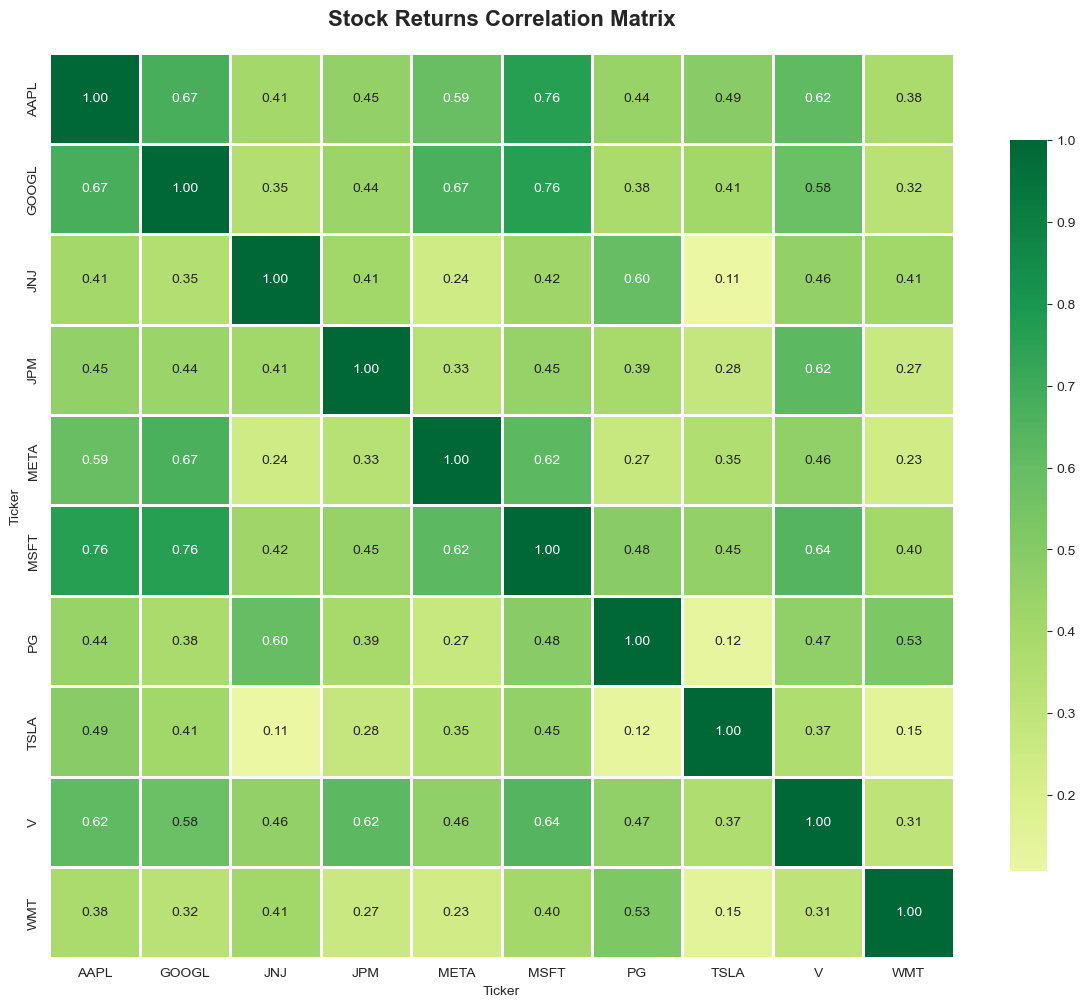


✓ Correlation analysis complete


In [17]:
# ============================================================
# CELL 9: CORRELATION ANALYSIS
# ============================================================

# Calculate correlation matrix
correlation_matrix = returns.corr()

print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)
print(f"\nAverage correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.2f}")
print(f"Max correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].max():.2f}")
print(f"Min correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].min():.2f}")

# Find most/least correlated pairs
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
corr_pairs = upper_tri.stack().sort_values(ascending=False)

print(f"\nMost correlated pairs:")
for i in range(3):
    print(f"  {corr_pairs.index[i][0]} - {corr_pairs.index[i][1]}: {corr_pairs.iloc[i]:.2f}")

print(f"\nLeast correlated pairs:")
for i in range(-3, 0):
    print(f"  {corr_pairs.index[i][0]} - {corr_pairs.index[i][1]}: {corr_pairs.iloc[i]:.2f}")

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Stock Returns Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n✓ Correlation analysis complete")

In [19]:
# ============================================================
# CELL 10: FINAL SUMMARY REPORT
# ============================================================

print("="*70)
print("           PORTFOLIO RISK MANAGEMENT - FINAL REPORT")
print("="*70)

print(f"\n{'PORTFOLIO OVERVIEW':^70}")
print("-"*70)
print(f"Initial Investment:        ${initial_investment:>20,}")
print(f"Final Value:               ${portfolio_value.iloc[-1]:>20,.2f}")
print(f"Total Return:              {(portfolio_value.iloc[-1]/initial_investment - 1)*100:>19.2f}%")
print(f"Period:                    {data.index[0].date()} to {data.index[-1].date()}")

print(f"\n{'RETURN METRICS':^70}")
print("-"*70)
print(f"Annualized Return:         {portfolio_returns.mean() * 252 * 100:>19.2f}%")
print(f"Annualized Volatility:     {portfolio_returns.std() * np.sqrt(252) * 100:>19.2f}%")
print(f"Sharpe Ratio:              {(portfolio_returns.mean() * 252 - 0.02) / (portfolio_returns.std() * np.sqrt(252)):>20.2f}")
print(f"Sortino Ratio:             {sortino_ratio:>20.2f}")

print(f"\n{'RISK METRICS':^70}")
print("-"*70)
print(f"Maximum Drawdown:          {max_drawdown*100:>19.2f}%")
print(f"Best Day:                  {portfolio_returns.max()*100:>19.2f}%")
print(f"Worst Day:                 {portfolio_returns.min()*100:>19.2f}%")
print(f"Skewness:                  {portfolio_returns.skew():>20.2f}")
print(f"Kurtosis:                  {portfolio_returns.kurtosis():>20.2f}")

print(f"\n{'VALUE AT RISK (95% CONFIDENCE)':^70}")
print("-"*70)
print(f"Historical VaR:            ${abs(historical_var_dollar):>19,.2f}  ({historical_var*100:.2f}%)")
print(f"Parametric VaR:            ${abs(parametric_var_dollar):>19,.2f}  ({parametric_var*100:.2f}%)")
print(f"Monte Carlo VaR:           ${abs(monte_carlo_var_dollar):>19,.2f}  ({monte_carlo_var*100:.2f}%)")
print(f"CVaR (Expected Shortfall): ${abs(historical_cvar_dollar):>19,.2f}  ({historical_cvar*100:.2f}%)")

print(f"\n{'BACKTESTING RESULTS':^70}")
print("-"*70)
print(f"Expected Violation Rate:   {expected_violation_rate*100:>19.1f}%")
print(f"Historical VaR Violations: {hist_violation_rate*100:>19.2f}%  ({'PASS' if abs(hist_violation_rate - expected_violation_rate) < 0.02 else 'FAIL'})")
print(f"Parametric VaR Violations: {param_violation_rate*100:>19.2f}%  ({'PASS' if abs(param_violation_rate - expected_violation_rate) < 0.02 else 'FAIL'})")

print(f"\n{'TOP RISK CONTRIBUTORS':^70}")
print("-"*70)
for idx, row in risk_contrib_df.head(3).iterrows():
    print(f"{row['Ticker']:>10}: {row['% of Total Risk']:>6.1f}% of portfolio risk")

print("\n" + "="*70)
print("                    ✓ ANALYSIS COMPLETE")
print("="*70)

# Save report to file
report_filename = 'portfolio_risk_report.txt'
with open(report_filename, 'w') as f:
    f.write("="*70 + "\n")
    f.write("           PORTFOLIO RISK MANAGEMENT - FINAL REPORT\n")
    f.write("="*70 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    # ... (repeat all the print statements as f.write)

print(f"\n✓ Report saved to {report_filename}")

           PORTFOLIO RISK MANAGEMENT - FINAL REPORT

                          PORTFOLIO OVERVIEW                          
----------------------------------------------------------------------
Initial Investment:        $             100,000
Final Value:               $          335,273.62
Total Return:                           235.27%
Period:                    2019-01-02 to 2023-12-29

                            RETURN METRICS                            
----------------------------------------------------------------------
Annualized Return:                       26.88%
Annualized Volatility:                   22.84%
Sharpe Ratio:                              1.09
Sortino Ratio:                             1.37

                             RISK METRICS                             
----------------------------------------------------------------------
Maximum Drawdown:                       -30.59%
Best Day:                                 9.98%
Worst Day:                       